# Building a Transformer Trained on 'Common Reasoning'
### By Oliver Morris

## Inspiration

There is a lot of discussion about deep reasoning and many approaches being attempted. This is often preceded by discussion on causation being different to correlation, with the substantial amount of work being done by Professor Judea Pearl of UCLA, see his book "Causality: Models, Reasoning and Inference" which applies graph models to derive causality. See YouTube for a quick introduction! https://www.youtube.com/watch?v=ZaPV1OSEpHw

Since there is already so much work based on the graph and causality approach, this model will approach deep reasoning from 'left of field'.

The inspiration is GPT-3, the transformer based language model developed by OpenAI. This model excels at translation (mapping) tasks, it does not attempt to learn causation yet somehow it achieves some basic reasoning, albeit flawed: https://cs.nyu.edu/faculty/davise/papers/GPT3CompleteTests.html

The best reasoning machines we know of are human beings. Humans make their own way through the world and use experience to improve their assessments of cause and effect. As anyone has taught children knows, these assessments of causality can be inspired, or they can be awfully flawed! Children must be taught to reason effectively and the rigorous reasoning of mathematics does not come easily to many otherwise successful humans. There are many subjects upon which we must make conclusions, but where we struggle to disentangle causation from correlation. The vast majority of us certainly have not mastered the tools for modelling causation statistically, as per Prof Pearl's treatise. Yet, even without these tools we humans can be amazingly adaptable and successful.

One of the key motivations for using Prof Pearl's approach is because it can lead to models capable of giving a reason 'why' the answer is 'x'. This would be a giant leap for the usability of deep learning models. Meanwhile, some tools attempt to tame deep learning models by simplifying them into decision trees, showing how the weights of model guide the pinball of an input thru the pachinco machine of the neural network towards an output. This is useful, but not how humans describe their method for reaching a conclusion. 

Humans give a justification for a conclusion as an output, alongside the conclusion itself. They certainly do not describe the weights of the neurons in their head. To repeat, the justification, which is subtly different to causation, is an output of their 'model' as much as the output itself. We've all given reasons for our conclusions, which initally sound convincing but fail the test of logic. Clearly, our minds are hypothesising reasons for conclusions which are intuitively reached. This justification function is deeply wired in the human brain, we can be tempted into giving justifications for actions we have not even taken, see the split brain experiments. Here it is referred to as 'common reasoning', analogous to 'common sense'.

So, this 'left of field' approach is not a challenge to the advantages of statistical causality, not at all. It simply considers the human experience and hypothesises that models based on correlation may have more to give.


## This Model

A Transormer is proposed which is trained on pairs of clauses. The input is a clause describing an effect, the target is a cause of that effect. For example, "The chicken crossed the road, because it was hungry". The clause up to the word 'because' is the effect, the clause after the word 'because' is the cause. In this way the model is trained to hypothesise justifications (causes) for the effect. The term justification is preferred because the model is not really learning causality, how can we know why the chicken crossed the road? Instead, it is learning plausible justifications, just as people do.

Such justifications are hypotheses which could then be tested by another model which is trained using counter factuals, as per Professor Judea. But this implies a reinforcement model, an area which will not be explored here. 

Let's return to the justification 'transformer'. The data for training will be taken from the 2019 wikipedia dump, Wiki40b, available from huggingface.co and a standard dataset with Tensorflow Datasets. Wiki40b is parsed for sentences with the word 'because' or 'therefore'. Those sentences are then broken down into the cause and effect part of the sentence. The clauses are then embedded using BERT and presented to the Transformer.

## Future Model

Professor Pearl's work gives three levels to developing causal models; 

- *Association*. Learning by observing the data and its correlations. This is where transformers find themselves

- *Intervention*. Interacting with the environment to see what happens. Reinforcement learning is trained by interaction

- *Counterfactuals*. Hypothesis testing. Was it X that caused Y? What happens if X is removed from the mix?

This transformer is purely on level 1, learning by associations. Nevertheless, consider the first Word2Vec word embeddings which where the word vectors were positioned relative to each other such that we could perform 'word algebra'. For example, Queen = King - Man + Woman. It would be interesting to see whether we can perform similar operations on causes. BERT allows us to embed entire clauses, effects or causes, as single vectors upon which we could hope to apply such operations.

It would be especially interesting to analyse the changes due to counterfactuals in such a space. Consider the 'effect' clauses which have only one verb, we could prefix that verb with 'not' and expect the 'cause' to be substantially distanced from the same effect without 'not'. For example, consider our original example, "Why did the chicken cross the road" and we get "Because he was hungry". Let's negate the verb in the effect: "Why did the chicken *NOT* cross the road?" we'd expect something like "Because he was now full". We'd hope the two causes were dissimilar, a model could be refined by minimising the similarity in such training examples.

In [1]:

import os

# the huggingface datasets for model training
from datasets import load_dataset

# our standard data exploration and wrangling packages
import re
import random
import plotnine as p9
import pandas   as pd
import numpy    as np
import tqdm.notebook as tq

# set working directory
os.chdir('c:\\Users\\OliverMorris\\OneDrive\\Oliver\\0_OM\\Training\\DeepReasoning')
path = os.getcwd()
print(path)


c:\Users\OliverMorris\OneDrive\Oliver\0_OM\Training\DeepReasoning


In [2]:
# get the dataset 
dataset = load_dataset('wiki40b', 'en') #, split='test'

print(dataset.keys())
print(type(dataset['train']))

print('Length of training set:',   len(dataset['train']))
print('Length of validation set:', len(dataset['validation']))
print('Length of testing set:',    len(dataset['test']))

Reusing dataset wiki40b (C:\Users\OliverMorris\.cache\huggingface\datasets\wiki40b\en\1.1.0\4efc066a938719e75ab321a6cd1c7b05006dcaf338071cdd92ab5652d3c453b8)
dict_keys(['train', 'validation', 'test'])
<class 'datasets.arrow_dataset.Dataset'>
Length of training set: 2926536
Length of validation set: 163597
Length of testing set: 162274


In [44]:

# Let's inspect some examples...

# get 20 random samples of the data
sample_list= random.sample(range(len(dataset['train'])), 20)

small_dataset = dataset['train'].select(sample_list)

# print the first example
small_dataset[0]


{'wikidata_id': 'Q5004781',
 'text': "\n_START_ARTICLE_\nBácum Municipality\n_START_SECTION_\nYaqui Indians\n_START_PARAGRAPH_\nThe indigenous community is very large, with more than 9,000 residents identified as Yaqui in the 2000 census.\n_START_SECTION_\nEconomy\n_START_PARAGRAPH_\nThe Bácum Municipality's main economic activity is intensive agriculture, with more than 300 square kilometers under irrigation by canal.  The Yaqui River's water is used for irrigation in a system of canals. The main crops are wheat, corn, soybeans, barley, cotton, and garden vegetables, as well as seasonal crops such as alfalfa and some fruits. _NEWLINE_The coastline in the south is 12 kilometres (7.5\xa0mi) long.  Some fishing is practiced.  Industries are small, and consist chiefly of packing houses for vegetables and liquid fertilizer production.",
 'version_id': '3944630243645935402'}

In [91]:
# function to extract sentences which have the key words 'because' or 'therefore'.
# the function then separates the sentences in the chunk before the key word and the chunk after.

def get_sentences_with_word(the_dataset, searchword, cause_last=True):

    sentences = []

    pat_a = re.compile(r"[A-Z]{1}[^\._!?]*\b" + searchword + r"\b\s+[^.!?\n]*", re.M) # extract sentences which contain a keyword out of the larger text 
    pat_b = re.compile(r".+?(?=" + searchword + r")", re.M) # extract chunk of sentence before the searchword
    pat_c = re.compile(r"(?<=" + searchword + r").+", re.M) # extract chunk of sentence after the keyword
    
    # patterns for separating the sentence into cause and effect
    # eg for "I love ice cream because its sweet", cause is last, cause = "its sweet", effect="I love ice cream"
    # eg for "its sweet therefore I love ice cream", cause is first, cause = "its sweet", effect="I love ice cream"
    if cause_last:
        pat_effect = pat_b
        pat_cause  = pat_c
    else:
        pat_effect = pat_c
        pat_cause  = pat_b
    
    # loop thru each text
    for i in tq.tqdm(range(len(the_dataset))):

        # get next record
        text        = the_dataset[i]['text']
        wikidata_id = the_dataset[i]['wikidata_id']

        # remove periods (full stops) which aren't sentence endings
        # this is tough, won't be perfect
        text = text.replace("e.g.", "eg")
        text = text.replace("i.e.", "ie")
        
        # replace any instance of the ASCII encodable separator we use for the pandas file, which is a tilde ~ (ASCII 126)
        text = text.replace("~", "-")

        # remove any instance of the wiki40b tokens for end of sentence, replace with the fullstop marker ". "
        text = text.replace("\n_START_SECTION_\n", ". ")
        text = text.replace("\n_START_PARAGRAPH_\n", ". ")

        # extract sentences with the searchword, eg 'because'
        try:
            
            found_a = pat_a.findall(text)
            
        except AttributeError:
            found_a = ''
    
        # for each sentence with the searchword which was found within the text
        for j in range(len(found_a)):

            # separate the sentence into cause and effect chunks
            cause  = pat_cause.findall(found_a[j])[0]
            effect = pat_effect.findall(found_a[j])[0]

            # both chunks must be longer than 4 words to bother saving them
            if len(cause.split())>4 and len(effect.split())>4 :
                # append the cause and effect sentence chunks to the list
                sentences.append({'wikidata_id':wikidata_id, 'searchword':searchword, 'incidence':j, 'effect':effect, 'cause':cause})

    return sentences


In [95]:
# test the function on the short sample

sample_ext = get_sentences_with_word(the_dataset=small_dataset, searchword='because', cause_last=True)
sample_ext = pd.DataFrame(sample_ext)
sample_ext.to_csv(path_or_buf=os.path.join(path,'sentences_sample.csv'), index=False, sep='¬')

# Its important that we work from the version saved to file because thats what the final version will do
# get first wikidata id
sample_ext_id1 = sample_ext.iloc[0,]['wikidata_id']
print('\n')
print('Source Data from Wiki40b')
print('\n')
print( small_dataset[ [id=='Q431031' for id in small_dataset['wikidata_id']] ] )

print('\n')
print('First Extracted Sentence')

print('\n')
print('Effect')
print(sample_ext.loc[0,'effect'])
print('\n')
print('Cause')
print(sample_ext.loc[0,'cause'])

#print(pd.read_csv(os.path.join(path,'sentences_sample.csv'), sep='¬'))


100%|██████████| 20/20 [00:00<00:00, 1114.08it/s]

Source Data from Wiki40b


{'wikidata_id': ['Q431031'], 'text': ["\n_START_ARTICLE_\nVolunteer Point\n_START_PARAGRAPH_\nVolunteer Point is a headland on the east coast of East Falkland, in the Falkland Islands, north-northeast of Stanley, and east of Johnson's Harbour and Berkeley Sound._NEWLINE_It is at the end of a narrow peninsula, which protects Volunteer Lagoon. At its landward end is Volunteer Shanty, a well maintained outhouse, which was used by trekkers until a few years ago.\n_START_SECTION_\nStrategic value in Falklands War\n_START_PARAGRAPH_\nVolunteer Point is one of the easternmost points of the islands, but Cape Pembroke is the furthest east. During the Falklands War, Argentine commanders considered it a potential British landing point, because it was far from continental Argentine airbases (e.g. Rio Grande, Comodoro Rivadavia), and those at Pebble Island, but also a strategic foothold for any British force wishing to re

In [109]:
searchwords = [{'searchword':'because',  'cause_last':'True'} , 
               {'searchword':'therefore','cause_last':'False'} ]

datasplits  = ['train', 'test', 'validation']

for split in datasplits:

    causes_and_effects = []

    # get instances of causes and effects from wikipedia entries
    for pair in searchwords:
        print('\n')
        print("Datasplit:",split,". Searchword:", pair['searchword'], '\n')
        
        causes_and_effects = causes_and_effects.append(get_sentences_with_word( the_dataset= dataset[split],
                                                                                searchword = pair['searchword'], 
                                                                                cause_last = eval(pair['cause_last'])))

    # convert to pandas
    causes_and_effects = pd.DataFrame(causes_and_effects)

    # simply remove non ASCII characters, because these cannot be encoded by BERT
    causes_and_effects['cause']  = causes_and_effects['cause'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
    causes_and_effects['effect'] = causes_and_effects['effect'].apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))

    # save to file
    causes_and_effects.to_csv(path_or_buf=os.path.join(path,'sentences_'+split+'.csv'), index=False, sep='~', encoding='ascii')

#del causes_and_effects



  0%|          | 249/2926536 [00:00<19:44, 2471.27it/s]

Datasplit: train . Searchword: because 

  0%|          | 533/2926536 [00:00<18:02, 2702.75it/s]

Datasplit: train . Searchword: therefore 

  0%|          | 194/162274 [00:00<01:24, 1927.04it/s]

Datasplit: test . Searchword: because 

  0%|          | 219/162274 [00:00<01:24, 1917.61it/s]

Datasplit: test . Searchword: therefore 

  0%|          | 533/163597 [00:00<01:00, 2679.11it/s]

Datasplit: validation . Searchword: because 

  0%|          | 277/163597 [00:00<00:59, 2750.67it/s]

Datasplit: validation . Searchword: therefore 

100%|██████████| 163597/163597 [01:04<00:00, 2516.92it/s]


In [112]:
# let's look at some results from memory
causes_and_effects.sample(n=3)

,wikidata_id,searchword,incidence,effect,cause
25625,Q18344462,because,0,When they look for rare things (such as a jell...,the probability of success and the stakes are...
11633,Q65122069,because,5,The actual effectiveness of wargaming in this ...,officers use many tools to hone their decisio...
28754,Q22905833,therefore,3,lower compensation of the suppliers) worsen i...,If consumers tend to be higher income persons ...


In [3]:
# Let's also inspect the data we saved to file in the previous chunk
# Keen to prove there are no file encoding problems
causes_and_effects_sv = pd.read_csv(os.path.join(path,'sentences_train.csv'), sep='~', encoding='ascii' )

# get 3 random samples of the data
causes_and_effects_sv.sample(n=3)



,wikidata_id,searchword,incidence,effect,cause
226283,Q2349884,because,0,The price of these ships was 9 million and is ...,it was a part of the offset deal for the prev...
200028,Q462058,because,1,The guaranteed lending program was eliminated ...,of a widespread perception that the governmen...
439190,Q4931374,because,0,From 1841 until 1872 Somerville was run by the...,up to that point Somerville was still incorpo...


## Data Limitations

The above examples show how easily we can extract huge numbers of examples with which to train our model. It also shows the pitfalls of the data. We can easily imagine a human sentence saying "The chicken crossed the road because, well, it just did". Our model won't learn anything about causation in the real world from this or the thousands of other incomplete justifications to be found on wikipedia. But this is not the point, the model is intentionally being taught plausible justifications, which is certainly a currency in which humans trade. 

## Using BERT to get Embeddings from Text

Transformer models will happily accept the integer indexes of tokens and learn their own embeddings. However, Transformers are also slow to train. There may be advantage in presenting the transformer with embeddings from BERT, rather than expect it to learn them.

We'll use the huggingface BERT transformer and associated tokenizer to process the text into embedding vectors which we can then pass into our own transformer.
https://huggingface.co/transformers/model_doc/bert.html

The following code borrows from the Torch example at https://mccormickml.com/2019/05/14/BERT-word-embeddings-tutorial/




In [2]:
import torch
from transformers import BertTokenizer, BertModel

# OPTIONAL: if you want to have more information on what's happening, activate the logger as follows
import logging
#logging.basicConfig(level=logging.INFO)

# Load pre-trained model tokenizer (vocabulary)
# this is the huggingface BertTokenizer: https://huggingface.co/transformers/model_doc/bert.html
# it has a vocabulary of 30,522 tokens: https://medium.com/huggingface/multi-label-text-classification-using-bert-the-mighty-transformer-69714fa3fb3d
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

## Encoding Text in Preparation for Tokenisation

BERT can take as input either one or two sentences, and uses the special token SEP to differentiate them. The CLS token always appears at the start of the text, and is specific to classification tasks. The tokenzier ensures these special tokens are present

Both tokens are always required, however, even if we only have one sentence, and even if we are not using BERT for classification. That’s how BERT was pre-trained, and so that’s what BERT expects to see.

- 2 Sentence Input:

    - [[CLS]] The man went to the store. [[SEP]] He bought a gallon of milk.

- 1 Sentence Input:

    - [[CLS]] The man went to the store. [[SEP]]

We must encode the 'cause' and 'effect' clauses into the format BERT expects. We use this method to encode:

**tokenizer.encode_plustokenizer.encode_plus**

In [7]:
# here's an example
clause = "Here is the sentence I want embeddings for."
marked_text = "[CLS] " + clause + " [SEP]"

# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)

# Print out the tokens.
print (tokenized_text)

['[CLS]', 'here', 'is', 'the', 'sentence', 'i', 'want', 'em', '##bed', '##ding', '##s', 'for', '.', '[SEP]']


### The Tokenizer's Output

Notice how the word “embeddings” is represented:

'em', '##bed', '##ding', '##s'

The original word has been split into smaller subwords and characters. The two hash signs preceding some of these subwords are just our tokenizer’s way to denote that this subword or character is part of a larger word and preceded by another subword. So, for example, the ‘##bed’ token is separate from the ‘bed’ token; the first is used whenever the subword ‘bed’ occurs within a larger word and the second is used explicitly for when the standalone token ‘thing you sleep on’ occurs.

Why does it look this way? This is because the BERT tokenizer was created with a WordPiece model. This model greedily creates a fixed-size vocabulary of individual characters, subwords, and words that best fits our language data. Since the vocabulary limit size of our BERT tokenizer model is 30,000, the WordPiece model generated a vocabulary that contains all English characters plus the ~30,000 most common words and subwords found in the English language corpus the model is trained on. This vocabulary contains four things:

- Whole words
- Subwords occuring at the front of a word or in isolation (“em” as in “embeddings” is assigned the same vector as the standalone sequence of characters “em” as in “go get em” )
- Subwords not at the front of a word, which are preceded by ‘##’ to denote this case
- Individual characters
To tokenize a word under this model, the tokenizer first checks if the whole word is in the vocabulary. If not, it tries to break the word into the largest possible subwords contained in the vocabulary, and as a last resort will decompose the word into individual characters. Note that because of this, we can always represent a word as, at the very least, the collection of its individual characters.

As a result, rather than assigning out of vocabulary words to a catch-all token like ‘OOV’ or ‘UNK’, words that are not in the vocabulary are decomposed into subword and character tokens that we can then generate embeddings for.

So, rather than assigning “embeddings” and every other out of vocabulary word to an overloaded unknown vocabulary token, we split it into subword tokens ‘em’, ‘##bed’, ‘##ding’, ‘##s’ that will retain some of the contextual meaning of the original word. We can even average these subword embedding vectors to generate an approximate vector for the original word.

In [3]:
import time
import datetime
from joblib import delayed, Parallel

def get_indexed_tokens(text):

    # Add the special tokens.
    marked_text = '[CLS] ' + text  + ' [SEP]'

    # Split the sentence into tokens.
    try:
        tokenized_text = tokenizer.tokenize(marked_text)
    except:
        tokenized_text = ['[CLS]','[SEP]']

    # sometimes more than 512 tokens result, the model exceeds its limits
    # This throws an error which we handle by simply returning the start and end tokens
    # Later these clauses will be removed from the pandas tables of train/test/validate data
    if len(tokenized_text) > 512:
        tokenized_text = ['[CLS]','[SEP]']

    # Map the token strings to their vocabulary indices.
    indexes_of_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

    return indexes_of_tokens


In [22]:
from concurrent.futures import ThreadPoolExecutor, as_completed

# tokenise both 'cause' and 'effect' clauses for all datasets; training, testing and validation.
for filename in ['sentences_train.csv', 'sentences_test.csv', 'sentences_validation.csv']:

    # load file of saved clauses
    causes_and_effects_sv = pd.read_csv(os.path.join(path, filename), sep='~')

    # setup parallel processing
    n_cpus = os.cpu_count()
    executor = ThreadPoolExecutor(max_workers=n_cpus)

    # for both cause and effect clauses...
    for clause in ['cause', 'effect']:

        # tell us whats happening!
        print('Processing: ', filename, ', clause: ', clause, '\n')

        # setup blank list to receive results
        tokenized_idxs = []

        # setup list comprehension to process test into indexed tokens using parallelism
        indexed_tokens = [executor.submit(get_indexed_tokens, text) for text in tq.tqdm(causes_and_effects_sv[clause])]

        # yield parallel results and append to blank list
        for indexed_token in as_completed(indexed_tokens):
            tokenized_idxs.append(indexed_token.result())
    
        # record full results in new column in pandas dataframe
        causes_and_effects_sv[ clause + '_idxs' ] = tokenized_idxs

    # save pandas dataframe to file
    causes_and_effects_sv.to_csv(path_or_buf=os.path.join(path, filename), index=False, sep='~')


Processing:  sentences_train.csv , clause:  cause 




Processing:  sentences_train.csv , clause:  effect 




Processing:  sentences_test.csv , clause:  cause 




Processing:  sentences_test.csv , clause:  effect 




Processing:  sentences_validation.csv , clause:  cause 




Processing:  sentences_validation.csv , clause:  effect 



In [23]:
# let's look at what we made...
causes_and_effects_sv.head()



,wikidata_id,searchword,incidence,effect,cause,cause_idxs,effect_idxs
0,Q18200409,because,0,"At school, Harry proclaims to Conor that he wi...",he no longer sees [him],"[101, 2057, 2856, 1996, 2143, 2302, 4209, 2151...","[101, 4998, 2013, 2023, 1010, 17981, 2036, 169..."
1,Q4771251,because,0,This leads to the somewhat surprising observat...,"as the oxide grows thinner, the leakage goes ...","[101, 2049, 5915, 3930, 2144, 1996, 4134, 2018...","[101, 1996, 2277, 1997, 2702, 2319, 1010, 2328..."
2,Q1903279,because,0,It is a variation of the crows foot style of d...,of its readability and efficient use of drawi...,"[101, 1997, 1037, 5164, 1997, 6181, 1998, 2316...","[101, 1996, 2197, 2343, 28709, 12942, 4900, 20..."
3,Q15197036,because,0,"Based on surveys conducted in 1997 and 1998, t...",it supports small numbers of breeding endange...,"[101, 4897, 2063, 1005, 1055, 9872, 2003, 6827...","[101, 2065, 2136, 2372, 2907, 2067, 1998, 2024..."
4,Q4882660,because,0,They were postponed to September just a day be...,Kosovo's representative wanted to have Kosovo...,"[101, 1997, 1996, 16376, 4180, 1997, 4487, 649...","[101, 1996, 3732, 2003, 6887, 2891, 8458, 1025..."


### Sentence 0 and Sentence 1

BERT is trained on and expects sentence pairs, using 1s and 0s to distinguish between the two sentences. That is, for each token in “tokenized_text,” we must specify which sentence it belongs to: sentence 0 (a series of 0s) or sentence 1 (a series of 1s). For our purposes, sentence 0 will be the cause, sentence 1 will be the effect.

Next we need to convert our data to torch tensors and call the BERT model. 

The BERT PyTorch interface requires that the data be in torch tensors rather than Python lists, so we convert the lists here - this does not change the shape or the data.

In [4]:
# Let's load our data from file
from ast import literal_eval

def get_pandasfromcsv(filename):

    data = pd.read_csv(os.path.join(path,filename), sep='~')

    # The Pandas to_csv() function stores lists as strings, eg [1,2] becomes '[1,2]', this is because list objects are not native to the cells of pandas dataframes
    # we could have pickled the pandas object, but easier to simply 'evaluate' the string literal into a list. 
    data['cause_idxs' ] = data['cause_idxs'].apply(literal_eval)
    data['effect_idxs'] = data['effect_idxs'].apply(literal_eval)

    return data

train = get_pandasfromcsv('sentences_train.csv')
train.name = 'train'
testi = get_pandasfromcsv('sentences_test.csv')
testi.name = 'testi'
valid = get_pandasfromcsv('sentences_validation.csv')
valid.name = 'valid'

print('How many records do we have?')
print(train.name,' : ', len(train))
print(testi.name,' : ', len(testi))
print(valid.name,' : ', len(valid))


How many records do we have?
train  :  516382
testi  :  28665
valid  :  28940


### Clause Length

Some clauses are very long and some very short. All clauses will need to be padded to the same length for submitting to the model. So if we simply pad all clauses to the longest possible, then we will have huge tensors of mostly zeros (padding). Also, some clauses are very short and contain effectively no information from which the model can learn. It will be btter to crop the unsually long and unsually short clauses. 

To decide what max length to use we'll need to see the distribution of lengths, then aim for something like the 90th percentile.



Cause Sentences...
The longest sentence has a token length of:  436
The 80th percentile of sentences have token length of:  23.0


Effect Sentences...
The longest sentence has a token length of:  414
The 80th percentile of sentences have token length of:  23.0


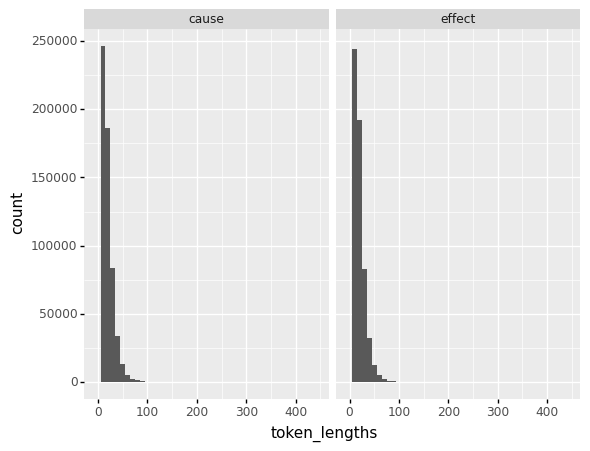

<ggplot: (-9223371919558747027)>

In [5]:

token_lengths_cause = []
token_lengths_effect= []

for dataset in [train, testi, valid]:
    token_lengths_cause  = token_lengths_cause  + [len(token_idxs) for token_idxs in dataset['cause_idxs']]
    token_lengths_effect = token_lengths_effect + [len(token_idxs) for token_idxs in dataset['effect_idxs']]

# where are the 80th percentiles?
print('Cause Sentences...')
print('The longest sentence has a token length of: ', np.max(token_lengths_cause))
cause_nth = np.percentile(token_lengths_cause,  70)
print('The 80th percentile of sentences have token length of: ', cause_nth)
print('\n')
print('Effect Sentences...')
print('The longest sentence has a token length of: ', np.max(token_lengths_effect))
effect_nth= np.percentile(token_lengths_effect, 70)
print('The 80th percentile of sentences have token length of: ', cause_nth)

# chart the distribution of token lengths as a histogram
# first we'll need a factor by which to draw the facets of the chart
# plottnine does not allow subplots, must use facets for multiple charts
token_factor = ['cause' for i in range(len(token_lengths_cause))] + ['effect' for i in range(len(token_lengths_effect))]

hist_data = pd.DataFrame({'token_lengths':token_lengths_cause + token_lengths_effect, 'token_factor':token_factor})
(
    p9.ggplot(hist_data, p9.aes(x='token_lengths'))
    + p9.geom_histogram(binwidth=10)
    + p9.facet_wrap('token_factor')
)



All sentences will have to be padded to the length of the longest sentence in the dataset. This will make for a huge amount of data, of which the vast majority will just be '0', the padding token. It will also increase the number of weights in the model and hence the training time. To simplify the project and work within our resources, we will remove the records with clause length greater than the 60th percentile

We will also remove the very short clauses, as they may be single words and other unuseful examples. This min_length has been arbitratily set at 10 tokens. This makes the range fairly narrow, so may assist training. Note, there are always at least 2 tokens, start token and finish token, so 10 tokens actually means 8 tokens of text.

The upshot is a clause range of 10 to 20 tokens for both the cause and the effect. This should aid training as all clauses will be of similar length.

In [6]:

max_length = int(max(cause_nth, effect_nth))

print('Before cropping the clauses...')
print('train data length:', len(train))
print('testi data length:', len(testi))
print('valid data length:', len(valid))

# Get mask for rows where both the cause and effects have a number of tokens between a minimum and the maximum.
# We don't want sentences too long, neither too short
# Minimum length has been arbitarily set to 10 tokens. Max length is calculated above.

min_length = 10
masks={}
for dataset in [train, testi, valid]:
    masks[dataset.name] = [ min_length <= len(cause)  <= max_length and
                            min_length <= len(effect) <= max_length for 
                            cause, effect in 
                            zip(dataset['cause_idxs'], dataset['effect_idxs']) ]

# apply those masks to filter out the longer records
# also reset the dataframe indexes, to extract batches we'll benefit from sequential indexes starting at 0
train = train[masks[train.name]].reset_index()
testi = testi[masks[testi.name]].reset_index()
valid = valid[masks[valid.name]].reset_index()

print('After cropping clauses to min_length=', min_length, ' tokens, and max_length=',max_length,' tokens.')
print('train data length:', len(train))
print('testi data length:', len(testi))
print('valid data length:', len(valid))


Before cropping the clauses...
train data length: 516382
testi data length: 28665
valid data length: 28940
After cropping clauses to min_length= 10  tokens, and max_length= 23  tokens.
train data length: 180092
testi data length: 10040
valid data length: 10038


## Pad Input Tokens

Now we need to apply the padding, so that all token vectors are of length = max_length

The index of the padding token for BERT is 0, we need to pad to max number of indexes for the batch

The final token must always be 102, so the padding 0s must be inserted before that final token. We could have padded whilst using the tokenizer, but we would end up saving huge files full of zeros.


In [7]:
# We will submit the data to BERT in batches and already padded 

def get_batch_for_BERT(batch, max_length=max_length):

    # apply the padding to max_length
    for i in range(len(batch)):

        # get pads to desired max_length
        padding = [0] * (max_length - len(batch[i]))

        # insert pads to list
        batch[i][-1:-1] = padding

    # get data in torch tensor format
    batch_token_idxs = torch.tensor( batch )

    # create the sentence segment ids, always same length, max_length
    segment_ids = len(batch) * [[0] * max_length]
    batch_segs  = torch.tensor( segment_ids )

    return batch_token_idxs, batch_segs

Let's inspect an example of converting inputs to PyTorch tensors

In [8]:
# specify an example
item = 'cause_idxs'
data = valid[item]

# extracxt an example batch of 3 records
# be sure to get a copy of the data, else the code will amend the pandas dataframe in place.
batch = data[0:3].tolist().copy()

# use the above function to convert the data into a batch for submission to BERT
batch_token_idxs, batch_segs = get_batch_for_BERT(batch)

print('Size of batch tensor for ',item,': ', batch_token_idxs.size(), '\n')
print('Example pytorch tensor of tokens for',item,'  : \n', batch_token_idxs[0],'\n')
print('Example pytorch tensor of segments for',item,': \n', batch_segs[0],'\n')


Size of batch tensor for  cause_idxs :  torch.Size([3, 23]) 

Example pytorch tensor of tokens for cause_idxs   : 
 tensor([  101, 24367,  2245,  1996,  2413,  2052,  2025,  4013,  3630, 17457,
         1996,  2773,  6892, 11178,     0,     0,     0,     0,     0,     0,
            0,     0,   102]) 

Example pytorch tensor of segments for cause_idxs : 
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) 



## Pad Target Tokens

We will seek embeddings only for the inputs. The target will not be embedded, primarily because its difficult to map embeddings back to tokens, hence back to human language. Whereas it is much easier to convert tokens to recognisable English.

The target of the model's training will be the token indexes. For example, if we input the embedding of an 'effect' then we would expect the model to output the token indexes for the predicted 'cause'. 

To enable losses between inputs and predictions we pad the target to the same length as the input, max_length. This is returned as a numpy array.

In [9]:
def pad_tokens(batch_of_tokens):

    # apply the padding to max_length
    for i in range(len(batch_of_tokens)):

        # get pads to desired max_length
        padding = [0] * (max_length - len(batch_of_tokens[i]))

        # insert pads to list, just before final token
        batch_of_tokens[i][-1:-1] = padding

    # convert to numpy
    batch_of_tokens = np.array(batch_of_tokens)

    return batch_of_tokens

## Using BERT

Calling BertModel.from_pretrained() will fetch the pretrained BERT model from huggingface. When we load the bert-base-uncased, we see the definition of the model printed in the logging. The model is a deep neural network with 12 layers. Explaining the layers and their functions is outside the scope of this post, and you can skip over this output for now.

model.eval() puts our model in evaluation mode as opposed to training mode. In this case, evaluation mode turns off dropout regularization which is used in training.

In [11]:
# Load pre-trained model (weights)
BERT_embedder = BertModel.from_pretrained('bert-base-uncased',
                                          output_hidden_states = True # Whether the model returns all hidden-states.
                                          )

# Put the model in "evaluation" mode, meaning feed-forward operation (any dropouts will be ignored)
BERT_embedder.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

Next, let’s evaluate BERT on our example text, and fetch the hidden states of the network!

Side note: torch.no_grad tells PyTorch not to construct the compute graph during this forward pass (since we won’t be running backprop here)–this just reduces memory consumption and speeds things up a little.

In [12]:
# Run the text through BERT, and collect all of the hidden states produced
# from all 12 layers. 
with torch.no_grad():

    outputs = BERT_embedder(batch_token_idxs, batch_segs)

    # Evaluating the model will return a different number of objects based on 
    # how it's  configured in the `from_pretrained` call earlier. In this case, 
    # becase we set `output_hidden_states = True`, the third item will be the 
    # hidden states from all layers. See the documentation for more details:
    # https://huggingface.co/transformers/model_doc/bert.html#bertmodel
    hidden_states = outputs[2]

## Understanding BERT's Output

The full set of hidden states for this model, stored in the object hidden_states, is a little dizzying. This object has four dimensions, in the following order:

- The layer number (13 layers)
- The batch number (1 sentence)
- The word / token number (22 tokens in our sentence)
- The hidden unit / feature number (768 features)

Wait, 13 layers? Doesn’t BERT only have 12? It’s 13 because the first element is the input embeddings, the rest is the outputs of each of BERT’s 12 layers. That’s 219,648 unique values just to represent our one sentence! The second dimension, the batch size, is used when submitting multiple sentences to the model at once; here, though, we just have one example sentence.

Grouping the values by layer makes sense for the model, but for our purposes we want it grouped by token.
Current dimensions:

- \[# layers, # batch_size, # tokens, # features\]
- e.g. \[ 0, 1, 2, 3]

Desired dimensions:

- \[# batch_size, # tokens, # layers, # features\]
- e.g. \[ 1, 2, 0, 3]

Luckily, PyTorch includes the permute function for easily rearranging the dimensions of a tensor. Let’s combine the layers to make this one whole big tensor. Then we can switch around the “layers” and “tokens” dimensions with permute.

In [13]:
def batch_stack(hidden_states):
    # Concatenate the tensors for all layers. 
    # We use `stack` here to create a new dimension in the tensor.
    token_embeddings = torch.stack(hidden_states, dim=0)

    # Swap dimensions so we have [batch_size, tokens, layers, features]
    token_embeddings = token_embeddings.permute(1,2,0,3)

    return token_embeddings

batch_embeddings = batch_stack(hidden_states)
size = list(batch_embeddings.size())
print('Tensor shape: [batch_size=',size[0],', tokens=',size[1],', layers=',size[2],', features=',size[3],']')


Tensor shape: [batch_size= 3 , tokens= 23 , layers= 13 , features= 768 ]


## Creating word and sentence vectors from hidden states

Now, what do we do with these hidden states? We would like to get individual vectors for each of our tokens, or perhaps a single vector representation of the whole sentence, but for each token of our input we have 13 separate vectors each of length 768.

In order to get the individual vectors we will need to combine some of the layer vectors…but which layer or combination of layers provides the best representation?

Unfortunately, there’s no single easy answer… Let’s try a couple reasonable approaches, though. Afterwards, I’ll point you to some helpful resources which look into this question further.

## Embedding Shape to Feed the Transformer

To get embedding vectors we could concatenate the last four layers, giving us a single word vector per token. Each vector would have length 4 x 768 = 3,072. Alternatively, we'll get smaller tensors if we simply sum the vectors, so each vector will retain length 768 (so, quarter the size).



In [14]:

def get_batch_of_sums(batch_embeddings):
    
    # shape of batch_embeddings  = [batch_size, tokens, layers, features]
    # This shape is achieved using a nested list comprehension
    # the outer layer of the nested list comprehension cycles thru all records, until 'batch_size' records have been processed
    # the shape at this stage is = [tokens, layers, features]
    # then the inner layer cycles thru each token and sums the token's values from the final 4 layers (-4:)
    # the shape at this stage is = [layers, features]
    # the result is a vector [batch_size, tokens, features]
    batch_of_sums = [[torch.sum(token[-4:,:], dim=0) for token in record] for record in batch_embeddings]

    return batch_of_sums

batch_of_sums = get_batch_of_sums(batch_embeddings)
print('Tensor shape: [batch_size=',len(batch_of_sums),', tokens=',len(batch_of_sums[0]),', features=',len(batch_of_sums[0][0]),']')


Tensor shape: [batch_size= 3 , tokens= 23 , features= 768 ]


## A Single Function to Get BERT Embeddings

Let's put these functions together:

- grab a batch of 32 records
- get embeddings from BERT
- then sum the last 4 layers of the embeddings

Then have this data ready to present as the input for a transformer model. The shape to be entered to the model should be \[batch_size, tokens, features]

In [15]:
# function of functions

def get_embeddings_and_tokens(batch, BERT_embedder, negate_padding=False):

    # get tokens (padded to max_length) and segment ids for the batch
    batch_token_idxs, batch_segs = get_batch_for_BERT(batch)

    # submit those tokens and segment ids to BERT
    with torch.no_grad():
        outputs = BERT_embedder(batch_token_idxs, batch_segs)
        hidden_states = outputs[2]

    # stack the resulting hidden states from BERT
    hidden_states_stacked = batch_stack(hidden_states)

    # sum the final 4 layers of the hidden states
    embeddings = get_batch_of_sums(hidden_states_stacked)

    # embeddings is a list of lists of torch tensors
    # convert to numpy for the sake of tensorflow transformer
    dim_a = len(batch) # number of examples per batch
    dim_b = max_length # number of tokens per example
    embeddings_np = np.array( [[ embeddings[i][j].tolist() for j in range(dim_b)] for i in range(dim_a) ] )

    # we may want to force our transformer to consider all informaiton in the embeddings
    # Whereas by default it will mask out embeddings in the position of padded tokens, ie where the token is 0
    # To achieve this, we set all padding (ie 0) tokens to 1 
    if negate_padding:
        batch_token_idxs = np.where(batch_token_idxs==0, 1, batch_token_idxs)

    # return the embeddings and the token indexes, both as numpy
    return embeddings_np, batch_token_idxs.numpy()

 Let's run this on an example

In [16]:
# specify a dataset for the example
dataset = valid

# extract the batch of causes and the matching batch of effects
# be sure to get a copy of the data, else the code will amend the pandas dataframe in place.
start_time = time.time()
batch_cause  = dataset['cause_idxs'][0:1000].tolist().copy()

# get the embeddings by submitting the tokens to the BERT model, returns np.array
batch_cause_embed, batch_cause_token = get_embeddings_and_tokens(batch=batch_cause,  BERT_embedder=BERT_embedder, negate_padding=False)

# get time
print("Time to extract 1000 embeddings= %s seconds" % (time.time() - start_time))

# print results of example to screen
print ('Shape of batch of embeddings of causes  [batch,tokens,features]: ', batch_cause_embed.shape)


Time to extract 1000 embeddings= 29.872174739837646 seconds
Shape of batch of embeddings of causes  [batch,tokens,features]:  (1000, 23, 768)


In [17]:
# Ouch, 27 seconds for 1000 embeddings. Torch is working in CPU mode, not using the GPU
# Each training epoch will need 180,000 embeddings
# So, 180k * 27s = 1hr20mins PER EPOCH, just to fetch embeddings
# If memory allows then we should precalculate all input embeddings
# inputs will be effects, targets will be causes
# The current training set of embeddings will be a 25GB file, this server can handle that in memory
# If it were much larger then the below code would have to be rewritten using a tool like DASK
import math

input_item  = 'effect_idxs'
batch_size  = 1024
batch_qty   = math.ceil(len(train)/batch_size)
batch_start = 0

if batch_size > len(train):
    raise Exception('batch size larger than data')

for i in tq.tqdm(range(batch_qty)):

    # get batch start/end
    batch_end   = batch_start + batch_size
    batch_end   = batch_end if batch_end < len(train) else len(train)

    # get data from pandas
    batch_input = train[input_item][batch_start:batch_end].tolist().copy()

    # get the embeddings by submitting the tokens to the BERT model, returns np.arrays
    batch_input_embed, batch_input_token = get_embeddings_and_tokens(batch=batch_input,  BERT_embedder=BERT_embedder, negate_padding=False)
    
    # append the result to numpy array
    if i == 0:
        train_input_embed = batch_input_embed
        train_input_token = batch_input_token
    else:
        train_input_embed = np.vstack((train_input_embed, batch_input_embed))
        train_input_token = np.vstack((train_input_token, batch_input_token))

    # increment batch
    batch_start = batch_end

# save to file
np.save(os.path.join(path,'train_input_embed.npy'), train_input_embed, allow_pickle=True)
print("Saved embeddings")
print("Embeddings shape = ", train_input_embed.shape)
print("---------------------")
np.save(os.path.join(path,'train_input_token.npy'), train_input_token, allow_pickle=True)
print("Saved tokens")
print("Tokens shape = ", train_input_token.shape)
print("---------------------")



Saved embeddings
Embeddings shape =  (180092, 23, 768)
---------------------
Saved tokens
Tokens shape =  (180092, 23)
---------------------


In [149]:
# load from file. train_input_embed is 25GB with 180,000 training clauses, 23 tokens per clause, 768 embeddings per token !
train_input_embed = np.load(os.path.join(path,'train_input_embed.npy'))
train_input_token = np.load(os.path.join(path,'train_input_token.npy'))


## Embeddings of Padding Tokens & Start/End Tokens

All clauses are now 36 tokens long with each token having an embedding of 768 values. Most of the clauses include some padding, this is where one or more tokens are '0'.

BERT returns one embedding for each token in a clause, BERT understands each tpoken in the context of other tokens. So, it returns a different embedding for each starting token (\[101]), for each ending token (\[102]) and for each padding token (\[0]).

It is difficult to know whether the BERT embedding for padding tokens is a meaningful 'pregnant silence' within the context of the other tokens. This is possible, or is it simply garbage that can be ignored? The MaskHandler, presented in a subsequent code chunk, is the tool which decides what the model considers and what it does not. That maskhandler builds its masks based on the token indexes for each clause, not on the embeddings. If it sees a 0, for padding, then it produces the mask which ignores data in that position. We can easily feed the maskhandler a dummy vector which has no padding (no 0 tokens), thus forcing the transformer to process all data in the embeddings. This is an option in the get_embeddings_and_tokens() function.

Meanwhile, let's inspect the data and see examples of 
- a) the differing embeddings for starting tokens of separate clauses
- b) the differing embeddings for padding tokens within the same clause



In [78]:
# The first token of all clauses is [101], the starting token
# Let's see first 5 values of the different embeddings for three different starting tokens...

print('Embedding for the starting token ([101]) in the 1st clause: ', batch_cause_embed[0][0][0:5])
print('Embedding for the starting token ([101]) in the 2nd clause: ', batch_cause_embed[1][0][0:5])
print('Embedding for the starting token ([101]) in the 3rd clause: ', batch_cause_embed[2][0][0:5])


Embedding for the starting token ([101]) in the 1st clause:  [-0.96379304 -0.88908547 -0.70942467 -1.6147567  -1.64514756]
Embedding for the starting token ([101]) in the 2nd clause:  [-1.37506938 -2.8377111  -0.42777041 -1.67681956 -2.81532383]
Embedding for the starting token ([101]) in the 3rd clause:  [-0.87999892 -1.23370218  0.35404122 -1.2326684  -0.45128268]


In [150]:
# here we inspect the differeing embeddings for padding tokens within the same clause
# then we confirm our ability to zero out padding embeddings 

print('Cause text  : ')
print(dataset['cause'][0],'\n')
print('Cause tokens: ')
print(dataset['cause_idxs'][0],'\n')
print('Penultimate two tokens, should both be padding [0]: ')
print(batch_cause_token[0][max_length-3:-1],'\n')
print('Penultimate token, a padding embedding, example values 1:5 of 768: ')
print(batch_cause_embed[0][max_length-2][0:5],'\n')
print('Prior token, also a padding embedding but with different values, example values 1:5 of 768: ')
print(batch_cause_embed[0][max_length-3][0:5],'\n')


Cause text  : 
 they are easily available and cheaper 

Cause tokens: 
[101, 24367, 2245, 1996, 2413, 2052, 2025, 4013, 3630, 17457, 1996, 2773, 6892, 11178, 0, 0, 0, 0, 0, 102] 

Penultimate two tokens, should both be padding [0]: 
[0 0] 

Penultimate token, a padding embedding, example values 1:5 of 768: 
[-2.73467731 -2.77842164 -1.02185428 -1.43788278  0.38926089] 

Prior token, also a padding embedding but with different values, example values 1:5 of 768: 
[ 1.2569313  -2.31451321  2.64633203 -1.93836582  3.66872072] 



# Tensorflow Preprocessing

The above code chunks extract the training data and inputs are passed through BERT to get embeddings. Those embeddings must presente dto a Transformer model which will train to output the cause of each inputted effect. This Transformer will be built in Tensorflow. Before going into the definition of the model there are a couple of data preprocessing tasks best handled by tensorflow:

- The first is positional encoding, to help the model understand the rerlative location of the token

- The second is to build that positional encoding into a preprocessing layer.


In [18]:
import tensorflow as tf

from tensorflow.keras.layers               import Layer, Dense, LayerNormalization, Embedding, Dropout
from tensorflow.keras.models               import Sequential, Model
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers           import Adam
from tensorflow.keras.losses               import SparseCategoricalCrossentropy
from tensorflow.keras.metrics              import Mean, SparseCategoricalAccuracy

import numpy as np
import matplotlib.pyplot as plt

## Positional Encoding

The meaning of the word (or token, or embedding vector) can depend on the position of that word in a sentence and on its relationship with other words in that same sentence. But the tranformer model contains no recurrence and no convolution, so the sequence in which the data is presented to the model is not usable by the model. For this reason the Transfomer will benefit from additional information about the relative position of every word in a sequence. 

That information is 'transferred' into the transformer by using a 'positional encoding' vector. This process is proposed in the “Attention is all you need” paper. The positional encoding vector (PE) is simply summed with the embeddings. The functions are sinusoidal, so can be extended over arbitrary clause lengths.

- PE<sub>pos,2i</sub> = sin(pos/1000<sup>2i/d</sup>)

- PE<sub>pos,2i+1</sub> = cos(pos/1000<sup>2i/d</sup>)

- where pos = value for position, i = possible positions, d = embedding_size (dims)

For example, consider situation where we have a batch of 3 examples of clauses each with 6 tokens and an embedding size (dimension) of 4 values per token.
The positional encoding method will return a tensor with shape (1, 6, 4), this is then broadcast over the batch of (3, 6, 4)

Let's see a couple of examples, first with the above simple values and then with the larger real tensor of our embeddings.

In [19]:
class PositionalEncoding(object):

    def __init__(self, tokens_per_clause, embedding_dim):

        angle_rads = self._get_angles(tokens_per_clause  = np.arange(tokens_per_clause)[:, np.newaxis], # get sequence of integers up to tokens_per_clause
                                      embedding_sequence = np.arange(embedding_dim)[np.newaxis, :],    # get sequence of integers up to embedding_dims
                                      embedding_dim      = embedding_dim)

        sines      = np.sin(angle_rads[:, 0::2])
        cosines    = np.cos(angle_rads[:, 1::2])

        self._encoding = np.concatenate([sines, cosines], axis=-1)
        self._encoding = self._encoding[np.newaxis, ...]
    
    def _get_angles(self, tokens_per_clause, embedding_sequence, embedding_dim):

        angle_rates = 1 / np.power(10000, (2 * (embedding_sequence//2)) / np.float32(embedding_dim))
        angle_rads  = tokens_per_clause * angle_rates

        return angle_rads
    
    def get_positional_encoding(self):
        
        encoding = tf.cast(self._encoding, dtype=tf.float32)

        return encoding

In [20]:
# example usage with simple values:

positional_encoding        = PositionalEncoding(tokens_per_clause=6, embedding_dim=4)
positional_encoding_values = positional_encoding.get_positional_encoding()

print("Imagine we have data where the clauses each have 6 tokens. Each token has an embedding vector with 4 values (embedding_dim=4).")
print("The positional encoder will return a (1,6,4) tensor with values representing each position in this space.")
print("These will later be summed with the input tensor [batch, tokens_per_clause, embedding_dim], so must share same shape:")
print("———–")
print(positional_encoding_values)
print("———–")

Imagine we have data where the clauses each have 6 tokens. Each token has an embedding vector with 4 values (embedding_dim=4).
The positional encoder will return a (1,6,4) tensor with values representing each position in this space.
These will later be summed with the input tensor [batch, tokens_per_clause, embedding_dim], so must share same shape:
———–
tf.Tensor(
[[[ 0.          0.          1.          1.        ]
  [ 0.84147096  0.00999983  0.5403023   0.99995   ]
  [ 0.9092974   0.01999867 -0.41614684  0.9998    ]
  [ 0.14112     0.0299955  -0.9899925   0.99955004]
  [-0.7568025   0.03998933 -0.6536436   0.9992001 ]
  [-0.9589243   0.04997917  0.2836622   0.99875027]]], shape=(1, 6, 4), dtype=float32)
———–


In [21]:
# our real parameters are: tokens_per_clause=36 and embedding_dims=768
# Let's see if we can sum the positional_encodings with an exmaple input batch
# The positional encodings are of course the same for each record in a batch
# so summing involves broadcasting the positional_encodings over the batch

positional_encoding        = PositionalEncoding(tokens_per_clause=batch_cause_embed.shape[1], embedding_dim=batch_cause_embed.shape[2])
positional_encoding_values = positional_encoding.get_positional_encoding()

print('Positional encoding tensor shape    : ', positional_encoding_values.shape)
print('Input embeddings tensor shape       : ', batch_cause_embed.shape)
print('Sum of the two tensors, output shape: ', (batch_cause_embed + positional_encoding_values).shape)

Positional encoding tensor shape    :  (1, 23, 768)
Input embeddings tensor shape       :  (1000, 23, 768)
Sum of the two tensors, output shape:  (1000, 23, 768)


## Pre Processing Layer

Both the Encoder and the Decoder employ a 'pre processing layer'. To be clear, the individual encoder and decoder blocks do not use this layer, it is applied only once for encoding and once for decoding.

The layer incorporates a standard keras embedding layer. An embedding layer is just a trainable look-up table: we give it a token (integer), which is the index of the word in the vocabulary, and it returns a trainable word-vector (embedding) for that index. The dimension of the vector returned by the embedding layer is set by embedding_dim, the same value is used in the encoder and decoder layers but referred to as num_neurons. In 'Attention is all you need' this dimension is 512, whereas we use 768 due this being the embedding size from BERT. This dimension is the same throughout the layers of the transformer. Note, a transformer is NOT an autoencoder where the encoder progressively shrinks the dims and the decoder progressively grows them.

To this embedding the layer then adds the above 'positional encoding'.

At the end of layer there is dropout, in order to avoid over-fitting

In [22]:
class PreProcessingLayer(Layer):

    def __init__(self, tokens_per_clause, vocabulary_size, embedding_dim):

        super(PreProcessingLayer, self).__init__()

        # Initialize
        self.embedding_dim = embedding_dim

        # instantiate embedding layer
        self.embedding = Embedding(vocabulary_size, self.embedding_dim)
        
        # get positional encoding, calculated up front and used on all tensors passing thru
        positional_encoding_handler = PositionalEncoding(tokens_per_clause=tokens_per_clause, embedding_dim=self.embedding_dim)
        self.positional_encoding    = positional_encoding.get_positional_encoding()

        # instantiate dropout
        self.dropout = Dropout(0.1)
    
    def call(self, inputs, training, apply_embedding):

        # IF inputting BERT embeddings with shape [batch, tokens_per_clause, BERT_embedding_dim]
        # then SKIP the embedding layer because the data is already embedded!
        # IF inputting integer indices, one per word token, then the embedding layer is required
        # Also, this embedding layer MUST remain for a layer instance serving a Decoder, even if using BERT for input
        # The layer learns an embedding for the input sequence, the output shape will be [batch, tokens_per_clause, embedding_dim]
        if apply_embedding:
            inputs = self.embedding(inputs)
        
        # this line is as per a recommendation in the Attention is all you need paper
        sequence = inputs * tf.math.sqrt(tf.cast(self.embedding_dim, tf.float32))

        # add embedding to positional encoding
        sequence = sequence + self.positional_encoding

        # apply dropout, if in training mode
        sequence = self.dropout(sequence, training=training)
        
        return sequence

# Tensorflow Transformer

The above code chuinks prepare the data. We may now move to defining the model. The transformer will be fairly standard and trained from scratch. It is possible to fine tune an existing transformer for many tasks, such as classification, as is described in the huggingface documentation at https://huggingface.co/transformers/master/custom_datasets.html. However, for text prediction tasks it may be better to train from scratch

The input will be the effect as an embedding. The target will be the cause as tokens. The predicted tokens will be easy to translate back to words, whereas BERT embeddings are not so easy to translate back to words as they are context specific.

Note, it could be trained the other way around, the cause could be the input and the target would be the effect

## TF2 Transformer From Scratch

Follows the standard TensorFlow Transformer for translation example:
https://github.com/tensorflow/tensor2tensor

Which was then adapted by N Zivkovic and N Djavic for a translation model, see link:
https://rubikscode.net/2019/09/30/transformer-series/

The code by Zivkovic and Djavic has then been adapted for use in this model. Their code is for a translation tool which learns its own embeddings, whereas this model is a sentence prediction tool which has embeddings submitted from BERT. Therefore, many changes have been made to adapt the code accordingly.

Whereas the BERT model was from PyTorch, this Transformer will be back in my homeground of TensorFlow, as it will be coded from scratch not simply fine tuning of an existing model.


## Masks

The heart of the Trensformer is the ScaledDotProductAttentionLayer class, which is used multiple times throughout the model. We need a mechanism to tell to this layer to ignore any padding in the data, because padding doesn’t carry any information. Our padding was originally represented by a '0' token, but BERT returns embedding values for 0 tokens. So, in the 'train' function (the last piece of code herein) we will use the tokens to derive a mask to pass to the Transformer, so it can know which embeddings have zero information. 

This assumes the BERT embeddings for padding tokens really do carry no information. We could easily ask the model the ignore this problem and assume all data is valid, this would be done by submitting a dummy vector to the maskhandler which has no padding

A second problem is that we must indicate to the model that it should only process words before the current word. This means that to predict the fourth word, only the first, second and the third word are used, but not the fifth.

Both of these problems, padding and future words, are solved using masks. For this purpose, we create the class MaskHandler:

In [23]:
class MaskHandler(object):

    def padding_mask(self, inputs):
        # The batch of sequences used to produce the mask will always be token sequences, not embeddings.
        # These batches of tokens have the shape: [batch, tokens_per_clause]
        # The masks produced herein are consumed by the ScaledDotProductAttentionLayer
        # This layer operates long after the data is embedded, either via BERT or via a keras embedding layer
        # so the mask is being applied to tokens, which have shape [batch, tokens_per_clause]

        # create a mask for padding tokens, note inverted. 1 for mask, 0 for pass
        sequence = tf.cast(tf.math.equal(inputs, 0), tf.float32)

        # expand dims
        sequence = sequence[:, tf.newaxis, tf.newaxis, :]
        
        return sequence

    def look_ahead_mask(self, size):
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        
        return mask

In [24]:
# Example usage
maskHandler = MaskHandler()

# a record is a series of embedding values for each token in a series of tokens
# so the shape for a batch of clauses will be [batch, tokens_per_clause] 
# Let's assume a simple example where batch=2, tokens_per_clause=4
# note the first example clause includes two padding tokens; 0, 0 
input_tokens = tf.constant([ [7, 7, 0, 0], 
                             [1, 3, 4, 1] ])

print('Embedding shape:', input_tokens.shape)

mask = maskHandler.padding_mask(inputs=input_tokens)
print('Padding Mask Example:')
print(mask)
print('———–')

mask = maskHandler.look_ahead_mask(size=input_tokens.shape[1])
print('Look Ahead Mask Example:')
print(mask)
print('———–')


Embedding shape: (2, 4)
Padding Mask Example:
tf.Tensor(
[[[[0. 0. 1. 1.]]]


 [[[0. 0. 0. 0.]]]], shape=(2, 1, 1, 4), dtype=float32)
———–
Look Ahead Mask Example:
tf.Tensor(
[[0. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 0.]], shape=(4, 4), dtype=float32)
———–


## Attention Layers

Attention is a concept that allows a Transformer to focus on specific parts of the sequence, i.e. sentence. It can be described as a mapping function, it maps a query and a set of key-value pairs to an output. Query, keys, values, and output are all vectors. The output is calculated as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key. The whole process can be divided into 6 steps:

- For each item of the input sequence three vectors are calculated: Query – q, Key – k and Value – v. They are calculated by applying three randomly initiated matrices, which are then trained. So Q, K and V are single Dense layers, so called 'linear' layers.

- Calculate the score for each item in the input sequence as the dot product of the Query vector versus each Key vector of the other items in the sequence. NB dot product outputs a scalar. 
    - For example, if we are calculating self-attention for the word “You”, the process creates a score for 'You' versus each word in the sentence. Meaning we calculate dot products of q(You) and k(You), q(You) and k(are) and q(You) and k(awesome). Note, the process scores the word against itself, hence 'self attention'.

- Divide the scores by 8 (other values could be used, but this is the default)

- Apply the softmax function. That way scores are standardised, positive and add up to 1

- Multiply the Value vector with the softmaxed score

- Sum all the results into a single vector thus we create the output of 'self-attention'.


## Scaled Dot-Product Attention

The attention used in a Transformer is best known as Scaled Dot-Product Attention. As in other attention layers, the input of this layer contains queries, keys (dimension d<sub>k</sub>) and values (dimension d<sub>v</sub>). We calculate the dot products of the query with all keys. Then we divide each by square root of dk and apply softmax. Mathematically this layer can be described with the formula:

Attention(Q,K,V) = softmax<sub>k</sub> (QK<sup>T</sup>/sqrt(d<sub>k</sub>))V

where<br>
d<sub>k</sub> is the dimension of the input of queries and keys<br>
d<sub>v</sub> is the dimension of the input of values<br>

In [25]:
class ScaledDotProductAttentionLayer():

    def calculate_output_weights(self, q, k, v, mask):

        qk = tf.matmul(q, k, transpose_b=True)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)

        scaled_attention = qk / tf.math.sqrt(dk)

        if mask is not None:
            scaled_attention += (mask * -1e9)  

        weights = tf.nn.softmax(scaled_attention, axis=-1)
        output  = tf.matmul(weights, v)

        return output, weights

## Multi-Head Attention Layer

Building on top of the previous layer, it has been noticed that when we linearly project the queries, keys and values n-times with different weight matrices and then concatenate the results, we get better performance. 

This means that instead of one single attention “head” (i.e. Scaled Dot-Product Layer), Q, K, and V are split into multiple “heads”. This way the model can attend to information at different positions from different 'representational' spaces, where these spaces attend to different language tasks given the model objective.

First this layer creates Q, K and V as dense layers in their own right, with their own weights. The size of each dense layer is the same, and is set by the param 'num_neurons'. The MHA custom layer passes the inputs through these dense layers and then splits them into three branches or “heads”. Each head gets the same values of Q, K and V. Then scaled dot-product attention is applied on each “head”, using its own weight matrix W. Results are then concatenated and passed to the final linear layer. Mathematically Multi-Head Attention Layer can be presented with the formula:

Multihead(Q, K, V) = Concat(head_1, ...heand_h)W<sup>O</sup>
<br> where <br>
head_i = Attention(QW<sup>Q</sup><sub>i</sub>, KW<sup>K</sup><sub>i</sub>, VW<sup>V</sup><sub>i</sub>)

In [26]:
class MultiHeadAttentionLayer(Layer):

    def __init__(self, num_neurons, num_heads):
        
        super(MultiHeadAttentionLayer, self).__init__()
        
        self.num_heads       = num_heads
        self.num_neurons     = num_neurons 
        self.depth           = num_neurons // self.num_heads
        self.attention_layer = ScaledDotProductAttentionLayer()

        if num_neurons % num_heads != 0:
            raise ValueError(f"embedding dimension = {num_neurons} should be divisible by number of heads = {num_heads}")
            # so num_heads must be a factor of embedding_dim.
            # If embedding_dim=768 then the factors are: 2, 3, 4, 6, 8, 12, 16, 24, 32, 48, 64, 96, 128, 192, 256, 384
        
        # Here's qeury q, key k and value v
        # all are dense layers with linear activation, which is the keras default
        self.q_layer = Dense(num_neurons)
        self.k_layer = Dense(num_neurons)
        self.v_layer = Dense(num_neurons)

        self.linear_layer = Dense(num_neurons)

    def split(self, x, batch_size):

        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, v, k, q, mask):
        
        batch_size = tf.shape(q)[0]

        # Run through linear layers
        q = self.q_layer(q)
        k = self.k_layer(k)
        v = self.v_layer(v)

        # Split the heads
        q = self.split(q, batch_size)
        k = self.split(k, batch_size)
        v = self.split(v, batch_size)

        # Run through attention
        # The attention layer applies softmax, which is the first non-linear activation of this data
        attention_output, weights = self.attention_layer.calculate_output_weights(q, k, v, mask)
        
        # Prepare for the rest of processing
        output = tf.transpose(attention_output, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(output, (batch_size, -1, self.num_neurons))
        
        # Run through final linear layer
        output = self.linear_layer(concat_attention)

        return output, weights

## Encoder, Decoder

There are typically 6 decoder blocks stacked on each other followed by 6 decoder blocks. This is not an autoencoder, each encoder block does not have a smaller output than the last. In a transformer all sub-layers in the model, as well as the embedding layers, produce outputs of the same dimension. In the original paper this was d<sub>model</sub> = 512, in our model it will be 768 to match BERT's embedding dim.

Each ENcoder block has the following layers: 
    
- MultiheadSelfAttention -> Dropout -> Add+Normalise -> 
- Dense -> Dense -> Dropout -> Add+Normalise

Each DEcoder block has the following layers: 
    
- MultiheadSelfAttention -> Dropout -> Add+Normalise -> 
- MultiheadSelfAttention -> Dropout -> Add+Normalise -> 
- Dense -> Dense -> Dropout -> Add+Normalise

## Encoder Block

Encoder = 
MultiheadSelfAttention -> Add+Normalise -> 2DenseLayers -> Dropout -> Add+Normalise


The two dense layers are called the 'feed forward network'.

In order to reduce training time, instead of using batch normalization, as we would for standard feed forward neural networks, we use modified approach called **layer normalization**. 

For reference, batch normalization uses the distribution of the summed input to a neuron over a mini-batch of training cases to compute a mean and variance which are then used to normalize the summed input to that neuron on each training case.

In layer normalisation we compute the mean and variance used for normalization from all of the summed inputs to the neurons in a layer on a single training case. Unlike batch normalization, layer normalization performs exactly the same computation at training and test times. It is also straightforward to apply to recurrent neural networks by computing the normalization statistics separately at each time step. Layer normalization is very effective at stabilizing the hidden state dynamics in **recurrent networks**.

This is all hidden from us if we use LayerNormalization from tensorflow.keras.layers.

Effectively, this means that we use layer normalization after each Multi-Head Attention or Feed Forward Neural Network Layer. Also, we use Dropout layer to avoid over-fitting. So, we create two helper functions that will build these layer combinations for us:


In [27]:
def build_multi_head_attention_layers(num_neurons, num_heads):

    # Multihead -> dropout -> layer normalisation
    multi_head_attention_layer = MultiHeadAttentionLayer(num_neurons, num_heads)   
    dropout                    = tf.keras.layers.Dropout(0.1)
    normalization              = LayerNormalization(epsilon=1e-6)

    return multi_head_attention_layer, dropout, normalization

def build_feed_forward_layers(num_neurons, num_hidden_neurons):

    feed_forward_layer = tf.keras.Sequential()

    # Two dense layers -> dropout -> layer normalisation
    feed_forward_layer.add(Dense(num_hidden_neurons, activation='relu'))
    feed_forward_layer.add(Dense(num_neurons))
    dropout       = Dropout(0.1)
    normalization = LayerNormalization(epsilon=1e-6)

    return feed_forward_layer, dropout, normalization

Now we can build encoder blocks, each comprised of sub layers which are discussed above

In [28]:
class EncoderBlock(Layer):

    def __init__(self, num_neurons, num_hidden_neurons, num_heads):

        super(EncoderBlock, self).__init__()

        # Instantiate multi head attention layer, with associated dropout and normalization
        self.multi_head_attention_layer, self.attention_dropout, self.attention_normalization = \
        build_multi_head_attention_layers(num_neurons, num_heads)   
            
        # Instantiate feed-forward network, with associated dropout and normalization
        self.feed_forward_layer, self.feed_forward_dropout, self.feed_forward_normalization = \
        build_feed_forward_layers(num_neurons, num_hidden_neurons)
       
    def call(self, inputs, training, mask):

        # Calculate attention output, encode using the padding mask
        attention_output, _ = self.multi_head_attention_layer(inputs=None, v=inputs, k=inputs, q=inputs, mask=mask)
        # apply dropout
        attention_output    = self.attention_dropout(attention_output, training=training)
        # apply normalization to sum of this MHA block AND inputs
        attention_output    = self.attention_normalization(inputs + attention_output)
        
        # Calculate output of feed forward network
        output = self.feed_forward_layer(attention_output)
        # apply dropout
        output = self.feed_forward_dropout(output, training=training)
        # apply normalization to sum of this feed forward block AND above MHA block
        output = self.feed_forward_normalization(attention_output + output)

        return output

## Decoder Block

The decoder layer is somewhat more complicated, because it has an additional Multi-Head Attention block


In [29]:
class DecoderBlock(Layer):

    def __init__(self, num_neurons, num_hidden_neurons, num_heads):
        super(DecoderBlock, self).__init__()

        # Instantiate multi head attention (MHA), with associated dropout and normalization
        self.multi_head_attention_layer1, self.attention_dropout1, self.attention_normalization1 =\
        build_multi_head_attention_layers(num_neurons, num_heads)   
        
        # The decoder needs a second multihead attention block, with associated dropout and normalization
        self.multi_head_attention_layer2, self.attention_dropout2, self.attention_normalization2 =\
        build_multi_head_attention_layers(num_neurons, num_heads)           

        # Instantiate feed-forward network, with associated dropout and normalization
        self.feed_forward_layer, self.feed_forward_dropout, self.feed_forward_normalization =\
        build_feed_forward_layers(num_neurons, num_hidden_neurons)

    def call(self, inputs, encoder_output, training, look_ahead_mask, padding_mask):

        # Decoder first MHA block
        attention_output1, attention_weights1 = self.multi_head_attention_layer1(inputs=None, v=inputs, k=inputs, q=inputs, mask=look_ahead_mask)
        ## apply dropout 
        attention_output1 = self.attention_dropout1(attention_output1, training=training)
        ## apply normalization to sum of this MHA block AND inputs
        attention_output1 = self.attention_normalization1(inputs + attention_output1)

        # Decoder second MHA block
        attention_output2, attention_weights2 = self.multi_head_attention_layer2(inputs=None, v=encoder_output, k=encoder_output, q=attention_output1, mask=padding_mask)
        ## apply dropout
        attention_output2 = self.attention_dropout1(attention_output2, training=training)
        ## apply normalization to sum of this MHA block AND above MHA block
        attention_output2 = self.attention_normalization1(attention_output1 + attention_output2)

        # Decoder feed forward network
        output = self.feed_forward_layer(attention_output2)
        ## apply dropout
        output = self.feed_forward_dropout(output, training=training)
        ## apply normalization to sum of this feed forward block AND above MHA block
        output = self.feed_forward_normalization(attention_output2 + output)

        return output, attention_weights1, attention_weights2

## Encoder + Decoder

In the “Attention is all you need” paper, authors suggest that we should use 6 Encoder blocks for building the Encoder and 6 Decoder blocks for building the Decoder. This is of course arbitrary, so we use a parameter to define how many encoder blocks there should be. 

Here is how the Encoder class, which encompasses the encoder blocks, now looks:

In [30]:
class Encoder(Layer):

    def __init__(self, num_neurons, num_hidden_neurons, num_heads, tokens_per_clause, vocabulary_size, num_enc_blocks = 6):

        super(Encoder, self).__init__()
        
        # How many encoder blocks to use...
        self.num_enc_blocks = num_enc_blocks

        # pre processing layer(self, tokens_per_clause, vocabulary_size, embedding_dim)
        self.pre_processing_layer = PreProcessingLayer(tokens_per_clause= tokens_per_clause, 
                                                       vocabulary_size  = vocabulary_size,
                                                       embedding_dim    = num_neurons)

        # There will be multiple encoder blocks, held in a list
        # Each of the feed forward blocks are of the SAME size
        # not shrinking, nor growing, as they might in a autoencoder.
        self.encoder_blocks = [EncoderBlock(num_neurons, num_hidden_neurons, num_heads) for _ in range(num_enc_blocks)]

    def call(self, inputs, training, mask, apply_embedding):

        # pre processing (embedding and positional vectors)
        sequence = self.pre_processing_layer(inputs         = inputs, 
                                             training       = training, 
                                             apply_embedding= apply_embedding)

        # The encoder is then comprised of a number of encoder blocks...
        # for each encoder block
        for i in range(self.num_enc_blocks):
            # execute the block on the output of the previous block
            sequence = self.encoder_blocks[i](inputs  = sequence, 
                                              training= training, 
                                              mask    = mask)

        return sequence

...and for the decoder, which encompasses a number of decoder blocks.

In [31]:
class Decoder(Layer):

    def __init__(self, num_neurons, num_hidden_neurons, num_heads, vocabulary_size, tokens_per_clause, num_dec_blocks=6):

        super(Decoder, self).__init__()

        # How many decoder blocks to use...
        self.num_dec_blocks = num_dec_blocks
        
        # Decoder also has preprocessing, because the decoded sentence embeddings prior to the current word are fed back into the decoder
        self.pre_processing_layer = PreProcessingLayer(tokens_per_clause= tokens_per_clause, 
                                                       vocabulary_size  = vocabulary_size,
                                                       embedding_dim    = num_neurons)

        # There will be multiple decoder blocks, held in a list
        # Each of the feed forward blocks are of the SAME size
        # not shrinking, nor growing, as they might in an autoencoder.
        self.decoder_blocks = [DecoderBlock(num_neurons, num_hidden_neurons, num_heads) for _ in range(num_dec_blocks)]

    def call(self, inputs, encoder_output, training, look_ahead_mask, padding_mask, apply_embedding):

        # pre processing. The decoder must always use the embedding layer, so this is defaults to True
        sequence = self.pre_processing_layer(inputs         = inputs,
                                             training       = training,
                                             apply_embedding= apply_embedding)
        
        # instantiate an empty dictionary to collect the decoder's attention weights
        attention_weights = {}

        # The decoder is then comprised of a number of decoder blocks...
        # ...so, for each decoder block...
        for i in range(self.num_dec_blocks):

            # execute the block on the output of the previous block                  
            sequence, attention_weights1, attention_weights2 = self.decoder_blocks[i](inputs         = sequence, 
                                                                                      encoder_output = encoder_output, 
                                                                                      training       = training, 
                                                                                      look_ahead_mask= look_ahead_mask, 
                                                                                      padding_mask   = padding_mask)

            # Different to the encoder, we will need the decoder's attention weights for the training process ...

            # ... get the weights from the decoder block's first MHA
            attention_weights['decoder_layer{}_attention_weights1'.format(i+1)] = attention_weights1

            # ... get the weights from the decoder block's second MHA       
            attention_weights['decoder_layer{}_attention_weights2'.format(i+1)] = attention_weights2

        
        return sequence, attention_weights

## The Transformer = Encoder + Decoder

We combine the encoder and decoder into a Transformer class and add the final Linear layer (ie a single dense layer) on top of that. 

It is important to notice that we inherited the Model class for the 'Transformer', because we are able to perform training and get predictions using this class. Apart from that, note that we need to pass on the masks that Encoder and Decoder use during the training process.

In [32]:
class Transformer(Model):

    def __init__(self, num_neurons, num_hidden_neurons, num_heads, tokens_per_clause, input_vocabulary_size, target_vocabulary_size, num_blocks):

        super(Transformer, self).__init__()

        # instantiate encoder
        self.encoder = Encoder(num_neurons       = num_neurons, # same as embedding_dim
                               num_hidden_neurons= num_hidden_neurons, 
                               num_heads         = num_heads, 
                               tokens_per_clause = tokens_per_clause,
                               vocabulary_size   = input_vocabulary_size, 
                               num_enc_blocks    = num_blocks)

        # instantiate decoder
        self.decoder = Decoder(num_neurons       = num_neurons, # same as embedding_dim
                               num_hidden_neurons= num_hidden_neurons, 
                               num_heads         = num_heads, 
                               tokens_per_clause = tokens_per_clause,
                               vocabulary_size   = target_vocabulary_size, 
                               num_dec_blocks    = num_blocks)

        # instantiate final dense layer to give probability distributions for each token
        # There will be 30522 possible tokens for BERT English, this is the vocabulary size
        # so the shape of predictions will be [batch, tokens_per_clause, vocabulary_size]. We will get a probability distribution per token.
        # Note, this is different to the targets, whose shape will be [batch, tokens_per_clause]. No probability ditribution, the value is certain.
        # This doesn't matter because our loss function wil be SparesCategoricalCrossEntropy with_logits=False,
        # This loss function assumes we provide a prob distribution for predictions and precise values for target. It then returns a loss per token
        self.linear_layer = Dense(target_vocabulary_size, activation='softmax')

    def call(self, inputs, training, encoder_padding_mask, look_ahead_mask, decoder_padding_mask, apply_embedding_enc, apply_embedding_dec):

        encoder_output = self.encoder(inputs   = inputs, 
                                      training = training, 
                                      mask     = encoder_padding_mask,
                                      apply_embedding = apply_embedding_enc)

        # decode (using the multiple decoder blocks that form a decoder model)
        # also get the attention weights!
        decoder_output, attention_weights = self.decoder(inputs          = inputs,
                                                         encoder_output  = encoder_output, 
                                                         training        = training, 
                                                         look_ahead_mask = look_ahead_mask, 
                                                         padding_mask    = decoder_padding_mask,
                                                         apply_embedding = apply_embedding_dec)

        # final dense layer
        output = self.linear_layer(decoder_output)

        return output, attention_weights

## Learning Rate Variation

Since we are following the “Attention is all you need” paper we use the Adam optimizer, as the authors of the article suggested. However, that paper also recommends that the learning rate varies, so we create a custom scheduler to do this.

### Scheduler and Optimizer

The formula used for changing the learning rate during training is:

lrate = d<sup>-0.5</sup><sub>model</sub> . min(step_num<sup>-0.5</sup>,  step_num . warmup_steps<sup>-1.5</sup> )

In a nutshell, the learning rate is increasing in the first part of the training. Namely, it is increasing until the number of training steps reaches the number 'warmup_steps'. After that learning rate decreases. This decrease is proportional to the 1/sqrt(step_num). 

In this paper, the value 4000 is used for warmup_steps, so we are doing the same. This means that for the first 4000 steps the learning rate will increase and then it will slowly downgrade.

This is implemented in the Schedule class:

In [33]:
class Schedule(LearningRateSchedule):

    def __init__(self, num_neurons, warmup_steps=4000):

        super(Schedule, self).__init__()

        self.num_neurons = tf.cast(num_neurons, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):

        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        lrate = tf.math.rsqrt(self.num_neurons) * tf.math.minimum(arg1, arg2)
        return lrate

Note that the above class inherits from LearningRateSchedule. Because of this we can pass an object of this class into the optimizer object and control the learning rate during the training process, like this:

In [64]:
# num_neurons is d_model, in 'Attention Is All You Need' it was set to 512
# It is also the embedding dimension, which is 768 for BERT base
# If rolling your own embeddings, then you can set this figure to something smaller
num_neurons = 8

learning_rate = Schedule(num_neurons=num_neurons)
optimizer = Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

## Padding the Loss Function

Since all sequences are padded, we need to apply a padding mask when the loss is calculated, so the prediction and target are padded to the same length.

As an objective function SparseCategoricalCrossentropy is used and it is padded using the 'padded_lossfunction' function.

Why SparseCategoricalCrossentropy?

Our tokens are 'categorical', one per word. Tokens are integers, there is not a continuos space of tokens. We will need a categorical loss function. There are so many tokens (categories) that its not reasonable to convert them to one-hot representations. So, we cannot use 'categorical cross entropy' to calculate the loss. 

Therefore, we use Sparse Categorical Crossentropy. See how it is calculated at: https://leakyrelu.com/2020/01/01/difference-between-categorical-and-sparse-categorical-cross-entropy-loss-function/

In [65]:
loss_objective_function = SparseCategoricalCrossentropy(from_logits=False, reduction='none')
# from_logits; logits are outputs which have NOT been normalized via Softmax or Sigmoid.
# In our case, we are providing a probability distribution because we have used softmax, so from_logits=False
# reduction;  normally set to 'auto', which computes the categorical cross-entropy as the average of label*log(pred). 
# Setting the value to 'none' gives us a loss for each token. Computing a reduce_mean on this list would give us the same result as with reduction='auto'.
# We leave as 'none' because we want to apply a mask, because we don't want to compute losses on targetted padding. 
# We added the padding to the target, errors (loss) versus this padding should be ignored in training

def padded_loss_function(targets, predictions):
    
    # get a mask of where the prediction matches the target
    mask = tf.math.logical_not(tf.math.equal(targets, 0))

    # apply SparseCategoricalCrossentropy
    # to the target vs the prediction
    loss = loss_objective_function(targets, predictions)

    # apply the mask
    mask = tf.cast(mask, dtype=loss.dtype)
    loss = loss * mask

    # 'reduce' the loss from one loss per token to a single value per clause
    loss = tf.reduce_mean(loss)

    return loss

training_loss = Mean(name='training_loss')
training_accuracy = SparseCategoricalAccuracy(name='training_accuracy')

## Training Process

Finally we can start the training process. First we need to initialize all necessary parameters and instantiate the an object of the Transformer class

In [66]:
# Instantiate helpers
maskHandler = MaskHandler()

## INITIALISE PARAMETERS
# num_blocks is the number of encoder blocks in the Encoder
# It is also the number of decoder blocks in the Decoder
num_blocks = 4

# num_neurons is d_model, in 'Attention Is All You Need' it was set to 512
# It is also the embedding dimension, which is 768 for BERT base
# If rolling your own embeddings, then you can set this figure to something smaller
num_neurons = 768

# num_hidden_neurons is the hidden dimension in the two dense layers which form the feed forward layers in the MHA, 
# It is typically larger than num_neurons
num_hidden_neurons = 1024

# num_heads is the number of attention heads, into which q,k and v are split.
# In the original paper this is set to 8, more is not necessarily better
# There is a constraint, num_heads must be a factor of d_model; num_neurons % num_heads = 0
# In our case, 768 / 8 = 96 
num_heads = 8

# vocabulary_size, the number of possible tokens given by the tokenizer
# If not using BERT embeddings, but rather rolling our own embeddings by inputting the tokens, 
# then this value is used by our own embedding layer, as defined in the pre-processing function
# In translation models we would use a tokenizer for each language so would have two vocabulary sizes; input and target
# The 'BERT Base uncased' tokenizer we used above is based on the following number of tokens for English
vocabulary_size = 30522

# Instantiate learning rate objects
learning_rate = Schedule(num_neurons)
optimizer     = Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# Instantiate transformer
transformer = Transformer(  num_blocks            = num_blocks, 
                            num_neurons           = num_neurons, 
                            num_hidden_neurons    = num_hidden_neurons,
                            num_heads             = num_heads,
                            tokens_per_clause     = max_length,
                            input_vocabulary_size = vocabulary_size, 
                            target_vocabulary_size= vocabulary_size)


## Train_step function.

This is the TensorFlow function that is in charge of the training process. This function receives two inputs, ie. two sequences, which are defined in the signature. 

In the beginning we need to create masks for the Encoder and Decoder. They are passed to the transformer function. Then we utilize GradientTape and make forward passes thru the Transformer.

We pick up the predictions and use them to calculate loss. For that, we use the padded function we defined previously. Once that is done, we utilize the optimizer and modify the Transformer's trainable parameters.

In the end we call training_loss and training_accuracy.

In [67]:
train_step_signature = [tf.TensorSpec(shape=(None, None, None), dtype=tf.float32), # input_embeddings [batch, tokens, embeddings]
                        tf.TensorSpec(shape=(None, None),       dtype=tf.int32),   # input_tokens     [batch, tokens]
                        tf.TensorSpec(shape=(None, None),       dtype=tf.int32)]   # target_tokens    [batch, tokens]
                       #tf.TensorSpec(shape=(),                 dtype=tf.bool)]    # apply_embedding, scalar boolean
#input_signature=train_step_signature
# the @tf.function decorator converts regular (eager) python code, which is easy to debug, 
# to graph based code, which is performance optimized.
@tf.function(input_signature = train_step_signature)
def train_step(input_embeddings, input_tokens, target_tokens):
    
    # Create masks
    encoder_padding_mask = maskHandler.padding_mask(inputs=input_tokens)
    decoder_padding_mask = maskHandler.padding_mask(inputs=input_tokens)
    
    look_ahead_mask             = maskHandler.look_ahead_mask(tf.shape(target_tokens)[1])
    decoder_target_padding_mask = maskHandler.padding_mask(target_tokens)
    combined_mask               = tf.maximum(decoder_target_padding_mask, look_ahead_mask)
    
    # Run training step
    with tf.GradientTape() as tape:
        
        # execute training
        predictions, _ = transformer(inputs               = input_embeddings,
                                     training             = True, 
                                     encoder_padding_mask = encoder_padding_mask,
                                     look_ahead_mask      = combined_mask, 
                                     decoder_padding_mask = decoder_padding_mask,
                                     apply_embedding_enc  = False, # If already inputting embeddings, then apply no further embedding.
                                     apply_embedding_dec  = False) # Else, if inputting tokens, then must use embedding layer for both encoder and decoder
        # get loss
        total_loss = padded_loss_function(targets=target_tokens, predictions=predictions)

    # get gradients, d.weights/d.loss, ie gradient of losses w.r.t weights
    gradients = tape.gradient(target=total_loss, sources=transformer.trainable_variables)

    # apply gradients to variables (weights)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    # get loss and accuracy
    training_loss(total_loss)
    training_accuracy(target_tokens, predictions)

In [68]:

start_time = time.time()

# parameters for training
dataset     = train
batch_size  = 32
epochs      = 5
data_length = len(dataset)
input_item  = 'effect_idxs'
target_item = 'cause_idxs'

# parameters for reporting batch results
batch_qty  = len(dataset)//batch_size + 1
report_freq= 10 # eg, report each 10% through the epoch (at 0%, 10%, 20% etc)
report_set = np.linspace(1,batch_qty, report_freq)
report_set = [round(x) for x in report_set]

for epoch in range(epochs):

    training_loss.reset_states()
    training_accuracy.reset_states()

    # reset the batch starting position
    batch_start = -1
    
    # initialise the epoch losses at 0
    sum_loss_epoch = 0

    # An epoch = randomly select a fixed number of batches from the data
    # We don't cycle though the data in the same order each time, so we 'shuffle' the data
    for batch_instance in range(batch_qty) : 

        # randomly select the next batch start
        while batch_start + batch_size > data_length or batch_start < 0:
            batch_start = random.randrange(0,data_length,1)
            batch_end   = batch_start + batch_size
        
        ## GET BATCH INPUTS

        # we prebuilt the embeddings from BERT and padded tokens in an earlier chunk...
        input_embeddings = train_input_embed[batch_start:batch_end]
        input_tokens     = train_input_token[batch_start:batch_end]

        ## GET BATCH TARGETS
        # get target tokens from pandas 
        target_tokens = dataset[target_item][batch_start:batch_end].tolist().copy()
        
        # ensure target tokens are padded and in numpy format
        target_tokens = pad_tokens(batch_of_tokens = target_tokens)

        # ensure all starting tokens, [CLS]=101, and ending tokens, [SEP]=102, are considered equivalent to padding because they are always the same
        # if these are not masked then the training tends to fixate on them and returns only a starting and ending token
        input_tokens[:, 0]  = 0 
        input_tokens[:,-1]  = 0
        target_tokens[:, 0] = 0 
        target_tokens[:,-1] = 0 

        ## EXECUTE TRAINING
        train_step(input_embeddings = tf.convert_to_tensor(input_embeddings, dtype=tf.float32),
                   input_tokens     = tf.convert_to_tensor(input_tokens,     dtype=tf.int32),
                   target_tokens    = tf.convert_to_tensor(target_tokens,    dtype=tf.int32))
                  #apply_embedding  = tf.convert_to_tensor(False,            dtype=tf.bool))
    
        # keep record of sum of epoch loss thus far
        sum_loss_epoch = sum_loss_epoch + training_loss.result()

        # print batch results each x% thru the data
        if batch_instance in report_set:
            print('Epoch={}, Percent complete={:.1f}%, Avg Loss Thus Far={:.6f}'.format(epoch, batch_instance/batch_qty*100, sum_loss_epoch/batch_instance))

        # reset batch start, so it will be randomly selected
        batch_start = -1

    # with training bar...
    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch, training_loss.result(), training_accuracy.result()))

# report how long the training took
print('Time to train = ',round((time.time() - start_time)/3600,1),' hours')

Epoch=0, Percent complete=0.0%, Avg Loss Thus Far=12.268033
Epoch=0, Percent complete=11.1%, Avg Loss Thus Far=5.329914
Epoch=0, Percent complete=22.2%, Avg Loss Thus Far=4.973799
Epoch=0, Percent complete=33.4%, Avg Loss Thus Far=4.806954
Epoch=0, Percent complete=44.5%, Avg Loss Thus Far=4.708857
Epoch=0, Percent complete=55.6%, Avg Loss Thus Far=4.644617
Epoch=0, Percent complete=66.7%, Avg Loss Thus Far=4.599178
Epoch=0, Percent complete=77.8%, Avg Loss Thus Far=4.565406
Epoch=0, Percent complete=88.9%, Avg Loss Thus Far=4.538999
Epoch 0 Loss 4.3410 Accuracy 0.0406
Epoch=1, Percent complete=0.0%, Avg Loss Thus Far=8.478209
Epoch=1, Percent complete=11.1%, Avg Loss Thus Far=4.302454
Epoch=1, Percent complete=22.2%, Avg Loss Thus Far=4.292505
Epoch=1, Percent complete=33.4%, Avg Loss Thus Far=4.286272
Epoch=1, Percent complete=44.5%, Avg Loss Thus Far=4.282969
Epoch=1, Percent complete=55.6%, Avg Loss Thus Far=4.280110
Epoch=1, Percent complete=66.7%, Avg Loss Thus Far=4.277248
Epoch

## Model Summary

Transformer models are famously large, and this is no exception. 
This quantity of trainable parameters was always going to take a long time to train:

In [69]:
transformer.summary()

Model: "transformer_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_3 (Encoder)          multiple                  15760384  
_________________________________________________________________
decoder_3 (Decoder)          multiple                  25209856  
_________________________________________________________________
dense_259 (Dense)            multiple                  23471418  
Total params: 64,441,658
Trainable params: 64,441,658
Non-trainable params: 0
_________________________________________________________________


In [70]:
## That took a few hours, so let's save the weights
# There are 343Mb of weights when saved in hdf format!

transformer.save_weights(os.path.join(path, 'transformer_weights_20201201.h5'))


## Sample Performance on Training data

Let's see how the model performs on some TRAINING examples before we evaluate the model on Test data


In [71]:
## GET SAMPLE INPUTS
# get input tokens from pandas
pandas_sample_eval = train.sample(n=3).reset_index(drop=True)
input_tokens_eval  = pandas_sample_eval[input_item].tolist().copy()
target_tokens_eval = np.array(pandas_sample_eval[target_item].tolist().copy())

# map those input tokens to embeddings by using BERT
# also get the input_tokens returned as numpy
input_embeddings_eval, input_tokens_eval = get_embeddings_and_tokens(batch         = input_tokens_eval, 
                                                                     BERT_embedder = BERT_embedder, 
                                                                     negate_padding= False)

# we have a subclassed model, so can't easily use the keras model.predict() method.
# Instead we execute our model with a function call...
# Happily, we can use the same masks as during training
encoder_padding_mask_eval = maskHandler.padding_mask(inputs=input_tokens_eval)
decoder_padding_mask_eval = maskHandler.padding_mask(inputs=input_tokens_eval)

look_ahead_mask_eval             = maskHandler.look_ahead_mask(tf.shape(input_tokens_eval)[1])
decoder_target_padding_mask_eval = maskHandler.padding_mask(input_tokens_eval)
combined_mask_eval               = tf.maximum(decoder_target_padding_mask_eval, look_ahead_mask_eval)

predictions, _ = transformer(inputs               = input_embeddings_eval,
                             training             = False, 
                             encoder_padding_mask = encoder_padding_mask_eval, 
                             look_ahead_mask      = combined_mask_eval, 
                             decoder_padding_mask = decoder_padding_mask_eval,
                             apply_embedding_enc  = False,  # We will feed the transformer with BERT embeddings, not tokens. So encoder needs no embedding.
                             apply_embedding_dec  = False)  # Decoder should always use a embedding layer

# predictions are softmax'ed probabilities for each token
# prediction shapes are [batch, tokens_per_clause, vocabulary_size]
# so we must select the most probable vocabulary member for each token
predictions = np.argmax(predictions, axis=-1)

# we can convert predicted token indexes back to readable(ish) tokens using the BERT tokenizer, 
predictions_text_dim2 = [tokenizer.convert_ids_to_tokens(prediction) for prediction in predictions]

# The tokenzier returns an array of one word for each token, these need joining together into a single sentence
predictions_text = [' '.join([x for x in prediction_text]) for prediction_text in predictions_text_dim2]

# remove token separations ' ##' and start and finish tokens, [CLS] and [SEP]
predictions_text = [prediction_text.replace(' ##', '')   for prediction_text in predictions_text]
predictions_text = [prediction_text.replace('[CLS]', '') for prediction_text in predictions_text]
predictions_text = [prediction_text.replace('[SEP]', '') for prediction_text in predictions_text]

# print predictions beside expected values
for i in range(len(predictions_text)):
    input_effect   = pandas_sample_eval['effect'][i]
    target_cause   = pandas_sample_eval['cause'][i]
    predicted_cause= predictions_text[i]
    print('=====================================')
    print('Example No      = ', i)
    print('Input Effect    = ', input_effect)
    print('Target Cause    = ', target_cause)
    print('Predicted Cause = ', predicted_cause)



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Example No      =  0
Input Effect    =  The school said that the relocation is needed 
Target Cause    =   the existing premises were overcrowded, and there are safety concerns
Predicted Cause =  the the the the the the the the the the the the the the the the the the the the the the the
Example No      =  1
Input Effect    =  In Cairo, Egypt's King Farouk asked her to sing; she refused 
Target Cause    =   Egypt had not recognized Free France and remained neutral
Predicted Cause =  he he he he he he he 

## Text Degeneration

The model is repeating common words and failing to learn. This is common in NLP. It is related to the decoder and/or the learning rate. 
There are a number of approaches which can be used to rectify the problem with the decoder:

https://colab.research.google.com/github/huggingface/blog/blob/master/notebooks/02_how_to_generate.ipynb

Repetition penalty looks like a useful candidate.
